In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
def SK_amort_count(bostadspris, kontant, bruttolon, SK_amorteringsgrans=4.5, SK_limit=6):
    
    if (bostadspris - kontant) / (bruttolon * 12) > SK_limit:
        SK_amort = 100
    elif 6 > (bostadspris - kontant) / (bruttolon * 12) > SK_amorteringsgrans:
        SK_amort = 0.01
    else:
        SK_amort = 0
        
    SK = (bostadspris - kontant) / (bruttolon * 12)
        
    return SK_amort, SK

def LTV_amort_count(bostadspris, kontant, forsta_amorteringsgrans=0.5, andra_amorteringsgrans=0.7):
    
    if (bostadspris - kontant)/bostadspris > forsta_amorteringsgrans:
        LTV_amort = 0.02
    elif 0.7 > (bostadspris - kontant)/bostadspris > andra_amorteringsgrans:
        LTV_amort = 0.01
    else:
        LTV_amort = 0
        
    LTV = (bostadspris - kontant)/bostadspris
        
    return LTV_amort, LTV

def amort_pct_func(kontant, bruttolon, bostadspris):
    
    LTV_amort, LTV = LTV_amort_count(bostadspris, kontant)
    SK_amort, SK = SK_amort_count(bostadspris, kontant, bruttolon)
    
    return LTV_amort + SK_amort, LTV, SK

def m_payment(bostadspris, ranta, manadsavgift, bruttolon, kontant, months_per_year=12):
    amort_pct, LTV, SK = amort_pct_func(kontant, bruttolon, bostadspris)
    manadskostnad = (bostadspris * LTV * amort_pct / months_per_year) + manadsavgift + (bostadspris * LTV * ranta / months_per_year)
    manad_amortering = (bostadspris * LTV * amort_pct / months_per_year)
    manad_ranta = (bostadspris * LTV * ranta / months_per_year)
    return manadskostnad, manad_amortering, manad_ranta, LTV, SK

def m_rantekostnad_kontant(lana_kontant, ranta_kontant, months_per_year=12):
    return lana_kontant * ranta_kontant / months_per_year

In [11]:
# Antal år att kolla över
N_year_sim = 3

# Egen kontantinsats
kontant = 85000 + 150*180 + 50000
# Månadslön brutto
bruttolon = 40000 + 28000
# Månadssparande
spara = 10000
# Löneökning per år i procent
loneokning_pct = 0.04
# Ränta på bolån
ranta = 0.015
# Ränta på lån för kontantinsats
ranta_kontant = 0.04
# Max skuldkvots-nivå
max_skuldkvot = 5.5

manadsavgift = 4000

In [12]:
kontant_vec = []
max_bostadspris = []

kostnad_vec = []
amort_vec = []
tot_ranta_vec = []
kontant_ranta_vec = []
lon_vec = []
lana_kontant_vec = []

LTV_vec = []
SK_vec = []

manad = []

for m in range(0,N_year_sim*12):
    
    if m != 0:
        kontant = kontant + spara
    # lana_kontant = max(kontant*2, 350000)
    if 350000>kontant*2:
        lana_kontant = kontant*2
    else:
        lana_kontant = 350000
    max_lan_SK = max_skuldkvot * bruttolon * 12
    bostadspris_ink = (kontant + lana_kontant) + max_lan_SK
    bostadspris_LTV = (kontant + lana_kontant) / 0.15
    bostadspris = min(bostadspris_ink, bostadspris_LTV)
    
    
    if m % 12 == 0 and m != 0:
        bruttolon = bruttolon * (1 + loneokning_pct)
        
    
    manadskostnad, manad_amortering, manad_ranta, LTV, SK = m_payment(bostadspris, ranta, manadsavgift, bruttolon, kontant + lana_kontant)
    manad_ranta_kontant = m_rantekostnad_kontant(lana_kontant, ranta_kontant)
    
    if SK > max_skuldkvot:
        print(f"För hög skuldkvot vid månad {m}, skuldkvot = {np.round(SK,2)}!")
    
    manad.append(m)
    kontant_vec.append(kontant)
    lana_kontant_vec.append(lana_kontant)
    max_bostadspris.append(bostadspris)
    kostnad_vec.append(manadskostnad + manad_ranta_kontant)
    amort_vec.append(manad_amortering)
    tot_ranta_vec.append(manad_ranta + manad_ranta_kontant)
    kontant_ranta_vec.append(manad_ranta_kontant)
    lon_vec.append(bruttolon)
    
    SK_vec.append(SK)
    LTV_vec.append(LTV)
    

In [13]:
tot_df = pd.DataFrame(
    {
        'Manad': manad,
        "Kontant": kontant_vec,
        "Lana_kontant": lana_kontant_vec,
        "Max_bostadspris": max_bostadspris,
        "Kostnad": kostnad_vec,
        "Amortering": amort_vec,
        "Tot_ranta": tot_ranta_vec,
        "Kontant_ranta": kontant_ranta_vec,
        "Bruttolon": lon_vec,
        "SK": SK_vec,
        "LTV": LTV_vec
    }
)

tot_df["Equity"] = tot_df["Kontant"] / tot_df["Max_bostadspris"]
tot_df["Nettolon"] = tot_df["Bruttolon"] * 0.7
tot_df["Cash"] = tot_df["Nettolon"] - tot_df["Kostnad"]
tot_df["Cash_EfterSpar"] = tot_df["Cash"] - spara

In [14]:
tot_df

,Manad,Kontant,Lana_kontant,Max_bostadspris,Kostnad,Amortering,Tot_ranta,Kontant_ranta,Bruttolon,SK,LTV,Equity,Nettolon,Cash,Cash_EfterSpar
0,0,162000,324000,3.240000e+06,13112.500000,4590.000000,4522.500000,1080.000000,68000.0,3.375000,0.850000,0.050000,47600.00,34487.500000,24487.500000
1,1,172000,344000,3.440000e+06,13675.000000,4873.333333,4801.666667,1146.666667,68000.0,3.583333,0.850000,0.050000,47600.00,33925.000000,23925.000000
2,2,182000,350000,3.546667e+06,13959.444444,5024.444444,4935.000000,1166.666667,68000.0,3.694444,0.850000,0.051316,47600.00,33640.555556,23640.555556
3,3,192000,350000,3.613333e+06,14124.722222,5118.888889,5005.833333,1166.666667,68000.0,3.763889,0.850000,0.053137,47600.00,33475.277778,23475.277778
4,4,202000,350000,3.680000e+06,14290.000000,5213.333333,5076.666667,1166.666667,68000.0,3.833333,0.850000,0.054891,47600.00,33310.000000,23310.000000
5,5,212000,350000,3.746667e+06,14455.277778,5307.777778,5147.500000,1166.666667,68000.0,3.902778,0.850000,0.056584,47600.00,33144.722222,23144.722222
6,6,222000,350000,3.813333e+06,14620.555556,5402.222222,5218.333333,1166.666667,68000.0,3.972222,0.850000,0.058217,47600.00,32979.444444,22979.444444
7,7,232000,350000,3.880000e+06,14785.833333,5496.666667,5289.166667,1166.666667,68000.0,4.041667,0.850000,0.059794,47600.00,32814.166667,22814.166667
8,8,242000,350000,3.946667e+06,14951.111111,5591.111111,5360.000000,1166.666667,68000.0,4.111111,0.850000,0.061318,47600.00,32648.888889,22648.888889
9,9,252000,350000,4.013333e+06,15116.388889,5685.555556,5430.833333,1166.666667,68000.0,4.180556,0.850000,0.062791,47600.00,32483.611111,22483.611111


<AxesSubplot:xlabel='Manad', ylabel='Max_bostadspris'>

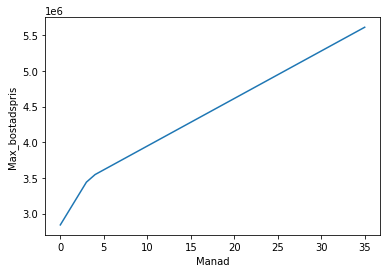

In [7]:
sns.lineplot(data=tot_df, x='Manad', y='Max_bostadspris')